# Clustering

In [233]:
# Useful libraries
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.sparse as sp
import scipy
from sklearn.cluster import KMeans
from wordcloud import WordCloud
tqdm.pandas()

/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Read the dataset

In [94]:
df=pd.read_csv('Reviews.csv')

In [95]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Number of unique products

In [96]:
df.ProductId.nunique()

74258

Number of total reviews

In [97]:
len(df)

568454

From some kaggle researches we noted there are some duplicates, for example the same User published the same rewiew at the same time for different products which belong to the same family but having different flavour (chocolate,nut,vanilla...) or different size packaging (package of 8,16,32 pieces). We decide to mantain only one unique review for this family product.

In [98]:
sorted_data=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [99]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

Then we decide to merge all the reviews written by different Users but refered to the same product. This passage is necessary for the future clustering operations, otherwise the same product can belong to differet clusters.

In [100]:
final_series=final.groupby('ProductId').Text.apply(lambda x :','.join(x))

In [31]:
final_df=pd.DataFrame(final_series).reset_index()

In [32]:
final_df

,ProductId,Text
0,0006641040,In June<br />I saw a charming group<br />of ro...
1,141278509X,This product by Archer Farms is the best drink...
2,2734888454,My dogs loves this chicken but its a product f...
3,2841233731,This book is easy to read and the ingredients ...
4,7310172001,My dogs love these treats. The only problems I...
...,...,...
67552,B009RSR8HO,I've been using Fat to Skinny Zero since it wa...
67553,B009SF0TN6,You have to try this sauce to believe it! It s...
67554,B009SR4OQ2,I bought this Hazelnut Paste (Nocciola Spread)...
67555,B009WSNWC4,Purchased this product at a local store in NY ...


# Preprocessing 

At this point we have an organized dataset and we can preprocess all the reviews, for example removing stopwords, normalizing and keeping only the stem of each word.

Then we decide to remove all the words with length of 2 or less, because with a quickly visual analysis we discover that there are some writing mistakes made by the Users or some special review such : **'G-R-E-A-T-P-R-O-D-U-C-T'** and we don't want to consider this special cases.

In [33]:
tokenizer = RegexpTokenizer(r'[a-z]+') 
stop_words = set(stopwords.words("english"))
stemmer= SnowballStemmer("english") # PorterStemmer 
new_text = []
for text in tqdm(final_df['Text']):
    letters = []
    words=tokenizer.tokenize(text.lower())
    tokens_without_sw = [stemmer.stem(word) for word in words if word not in stop_words]
    for t in tokens_without_sw:
        if len(t)>2:
            letters.append(t)
    new_text.append(letters)
    

100%|██████████| 67557/67557 [03:45<00:00, 299.64it/s]


In [34]:
final_df['Reviews_Text'] = new_text

In [35]:
final_df.drop(columns=['Text'],inplace=True)

In [36]:
final_df.head()

,ProductId,Reviews_Text
0,0006641040,"[june, saw, charm, group, rose, begin, droop, ..."
1,141278509X,"[product, archer, farm, best, drink, mix, ever..."
2,2734888454,"[dog, love, chicken, product, china, wont, buy..."
3,2841233731,"[book, easi, read, ingredi, avail, store, unli..."
4,7310172001,"[dog, love, treat, problem, encount, left, pow..."


In [37]:
final_df.to_csv('Final_df.csv')

## Upload the preprocessed dataset

In [38]:
df=pd.read_csv('Final_df.csv',index_col=0)

In [39]:
df.head()

,ProductId,Reviews_Text
0,0006641040,"['june', 'saw', 'charm', 'group', 'rose', 'beg..."
1,141278509X,"['product', 'archer', 'farm', 'best', 'drink',..."
2,2734888454,"['dog', 'love', 'chicken', 'product', 'china',..."
3,2841233731,"['book', 'easi', 'read', 'ingredi', 'avail', '..."
4,7310172001,"['dog', 'love', 'treat', 'problem', 'encount',..."


In [40]:
#for reading the column Reviews_Text as list
df['Reviews_Text']=df.Reviews_Text.progress_apply(lambda s: list(ast.literal_eval(s)))

100%|██████████| 67557/67557 [01:05<00:00, 1024.18it/s]


## Creating our TF_IDF
First we count the number of documents in which every word appears , this is useful for the computation of tfidf score.

In [44]:
# - keys: word
# - values: number of reviews in which the word appears
word_numberdoc = {}

for text in tqdm(df['Reviews_Text']):
    p = list(set(text))
    for word in p:
        if word in word_numberdoc:
            word_numberdoc[word]+=1
        else:
            word_numberdoc[word]=1  


100%|██████████| 67557/67557 [00:03<00:00, 17147.13it/s]


In [46]:
with open('word_numberdoc.pkl', 'wb') as handle:
    pickle.dump(word_numberdoc, handle)

We decide to mantain all that words that are at least in 10 reviews and at most in 100000 reviews. This choice is made because the words which are in few reviews aren't meaningful because they are not enough to identify a product. Instead words that appear in too many reviews caracterize almost all the product so they aren't so important for the clustering. The result is saved in separated dict.

In [47]:
# - keys: word
# - values: number of reduced reviews in which the word appears 
word_numberdoc_useful = {}

for key, value in tqdm(word_numberdoc.items()):
    if value >= 10 and value <= 100000:
        word_numberdoc_useful[key] = value

100%|██████████| 78973/78973 [00:00<00:00, 1827150.30it/s]


Excluding the words with low document frequency and with high frequency, we reduce the original number of words from approximately 78900 to 14573.


In [49]:
with open('word_numberdoc_useful.pkl', 'wb') as handle:
    pickle.dump(word_numberdoc_useful, handle)

In [50]:
with open('word_numberdoc_useful.pkl', 'rb') as handle:
    word_numberdoc_useful = pickle.load(handle)

We map all the word with an integer and save them in a vocabulary.

In [51]:
# - keys: word
# - values: index of the word
useful_vocabulary={}
for i,word in enumerate(word_numberdoc_useful):
    useful_vocabulary[word]=i    

In [52]:
with open('useful_vocabulary.pkl', 'wb') as handle:
    pickle.dump(useful_vocabulary, handle)

In [53]:
with open('useful_vocabulary.pkl', 'rb') as handle:
    useful_vocabulary = pickle.load(handle)

At this point, we can compute the TfIdf score, according to the changes we made.

In [103]:
# - keys: index number of a word
# - values: {review in which the word appears, score of the word with respect to the review}
N_doc = len(df)
tfidf = defaultdict(list)

count = 0
for text in tqdm(df['Reviews_Text']):
    n=len(text)
    n_ij=dict(Counter(text))
    for word in n_ij:
        if word in word_numberdoc_useful.keys():
            tf=n_ij[word]/n
            Idf=np.log(N_doc/word_numberdoc_useful[word])
            tfidf[useful_vocabulary[word]].append((count,round(tf*Idf,5)))
        
    count += 1

100%|██████████| 67557/67557 [00:52<00:00, 1280.49it/s]


In [104]:
with open('tfidf_useful_word.pkl', 'wb') as handle:
    pickle.dump(tfidf, handle)

In [105]:
with open('tfidf_useful_word.pkl', 'rb') as handle:
    tfidf_useful_word = pickle.load(handle)

Once we have the tfidf we create a sparse matrix with size [number of reviews,number of features], the non-zero values are the tf_idf scores for that review and the corrispondent words which contains. 

In [58]:
rows, cols, vals = [], [], []
for key, values in tqdm(tfidf_useful_word.items()):
    for value in values:
        rows.append(value[0])
        cols.append(key)
        vals.append(value[1])

X = sp.csr_matrix((vals, (rows, cols)))

100%|██████████| 14573/14573 [00:02<00:00, 6763.90it/s]


Here we import the TruncatedSVD model for dimensionality reduction of sklearn, and we calculate the variance explained by different number of features to be able to find the number which explains more than the 60% of the variance.

In [60]:
from sklearn.decomposition import TruncatedSVD

In [61]:
n_comp = [4,10,15,20,50,100,150,200,500,700,800] 
explained_ = [] 
for x in tqdm(n_comp):
    svd = TruncatedSVD(n_components=x)
    svd.fit(X)
    explained_.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

  9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

Number of components = 4 and explained variance = 0.023372309133083396


 18%|█▊        | 2/11 [00:02<00:09,  1.07s/it]

Number of components = 10 and explained variance = 0.04502301745143647


 27%|██▋       | 3/11 [00:03<00:09,  1.19s/it]

Number of components = 15 and explained variance = 0.057641359566548846


 36%|███▋      | 4/11 [00:05<00:09,  1.33s/it]

Number of components = 20 and explained variance = 0.06849020358363807


 45%|████▌     | 5/11 [00:08<00:11,  1.91s/it]

Number of components = 50 and explained variance = 0.11704679013847143


 55%|█████▍    | 6/11 [00:14<00:16,  3.27s/it]

Number of components = 100 and explained variance = 0.17231321487035609


 64%|██████▎   | 7/11 [00:24<00:20,  5.24s/it]

Number of components = 150 and explained variance = 0.2142230501314303


 73%|███████▎  | 8/11 [00:36<00:21,  7.31s/it]

Number of components = 200 and explained variance = 0.24941187111889895


 82%|████████▏ | 9/11 [01:15<00:33, 16.54s/it]

Number of components = 500 and explained variance = 0.39823140598363005


 91%|█████████ | 10/11 [02:05<00:26, 26.70s/it]

Number of components = 700 and explained variance = 0.46844681777854585


100%|██████████| 11/11 [03:05<00:00, 16.88s/it]

Number of components = 800 and explained variance = 0.49851030429353405


In [62]:
n_comp = [1200, 1500]
for x in tqdm(n_comp):
    svd = TruncatedSVD(n_components=x)
    svd.fit(X)
    explained_.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

 50%|█████     | 1/2 [01:41<01:41, 101.21s/it]

Number of components = 1200 and explained variance = 0.5959196782893105


100%|██████████| 2/2 [03:52<00:00, 116.45s/it]

Number of components = 1500 and explained variance = 0.6517713132551776


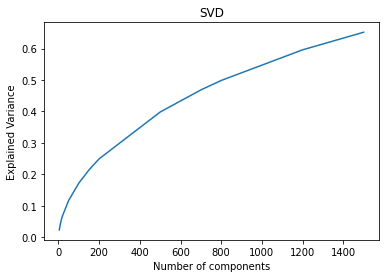

In [67]:
plt.plot(n_comp, explained_)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("SVD")
plt.show()

As shown in the graph above, from the results obtaind from the SVD Truncated method for the reduction of the number of features, we can note the words that explain the 65% of the variance of the reviews are 1500.

Therefore each review instead of being represented with 14k old features we can represent each review with top 1500 components obtained from the truncated SVD.

## Find the best 1500 features

SVD dimension are linear combination of the original features. So for finding the 1500 features that explain 65% of the data we:
1. Obtain all the features(words) from an inverted vocabulary dictionary, where each index is mapped in each word.

2. We order the features in decreasing order using the svd.components which is a matrix of coefficient of each features are multiplied by. 

3. To obtain the top 1500 we sort the first dimension of svd_components and we find the relative features

In [97]:
# create an inverted vocabulary index 
# - keys: index number of a word
# - values: word
inverted_useful_vocabulary=defaultdict(list)
for i,word in enumerate(word_numberdoc_useful):
    inverted_useful_vocabulary[i]=word

In [116]:
best_features = [inverted_useful_vocabulary[i] for i in svd.components_[0].argsort()[::-1]]

In [117]:
print(best_features[:1500])

['tea', 'coffe', 'flavor', 'tast', 'chocol', 'dog', 'love', 'great', 'like', 'good', 'product', 'use', 'order', 'bag', 'one', 'drink', 'candi', 'tri', 'food', 'price', 'buy', 'make', 'sauc', 'best', 'get', 'would', 'find', 'cup', 'realli', 'amazon', 'box', 'time', 'cat', 'sweet', 'eat', 'store', 'green', 'sugar', 'treat', 'mix', 'purchas', 'much', 'delici', 'cooki', 'hot', 'packag', 'littl', 'brand', 'ship', 'well', 'recommend', 'bar', 'gift', 'nice', 'better', 'favorit', 'bought', 'fresh', 'look', 'enjoy', 'also', 'bean', 'year', 'perfect', 'even', 'bottl', 'high', 'pack', 'qualiti', 'day', 'ever', 'found', 'wonder', 'want', 'salt', 'free', 'arriv', 'snack', 'made', 'ice', 'water', 'organ', 'add', 'excel', 'item', 'give', 'local', 'got', 'first', 'receiv', 'way', 'work', 'need', 'hard', 'oil', 'say', 'differ', 'milk', 'could', 'soup', 'smell', 'rice', 'cook', 'chees', 'think', 'spice', 'lot', 'chicken', 'strong', 'tasti', 'stuff', 'black', 'bit', 'thank', 'know', 'pasta', 'quick', 'bl

In [118]:
best_features_1500 = best_features[:1500]

We create a TfIdf dictionary mapping only the best 1500 features from the svd.components.

In [140]:
# create an vocabulary index with only 1500 words
# - keys: word
# - values: index number of a word
vocabulary_1500={}
i=0
for elem in best_features_1500:
    vocabulary_1500[elem]=i
    i+=1

In [143]:
# create a TfIdf dict with only the best 1500 words
# - keys: index number of a word
# - values: {review in which the word appears, score of the word with respect to the review}
N_doc = len(df)
tfidf_1500 = defaultdict(list)

count = 0
for text in tqdm(df['Reviews_Text']):
    n=len(text)
    n_ij=dict(Counter(text))
    for word in n_ij:
        if word in best_features_1500:
            tf=n_ij[word]/n
            Idf=np.log(N_doc/word_numberdoc_useful[word])
            tfidf_1500[vocabulary_1500[word]].append((count,round(tf*Idf,5)))
        
    count += 1

100%|██████████| 67557/67557 [02:18<00:00, 488.78it/s] 


We initialize a matrix of shape (67557,1500) where the rows are the number of unique ProductId of the dataset and the columns the number of words that explain the 65% of the variance of the reviews.

In [144]:
a=np.zeros((67557,1500),dtype='float32')

We fill the matrix with the TfIdf dictionary of the best 1500 words.

In [145]:
for key,value in tqdm(tfidf_1500.items()):
    for va in value:
        a[va[0],key]=va[1]

100%|██████████| 1500/1500 [00:05<00:00, 261.52it/s]


Here we create the new dataframe where the rows are the number of unique products and the columns are the ProdcutId and the best 1500 words.

In [147]:
matrix_df = pd.DataFrame(a,columns=best_features_1500)
matrix_df.insert(loc=0,column='ProductId',value=df['ProductId'])

In [149]:
matrix_df.head()

,ProductId,tea,coffe,flavor,tast,chocol,dog,love,great,like,...,attent,burnt,bore,toler,cola,human,tortilla,thumb,tassimo,macadamia
0,0006641040,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.01074,0.00703,0.00354,...,0.00290,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,141278509X,0.0,0.00000,0.04172,0.01719,0.0,0.00000,0.00000,0.01949,0.00000,...,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,2734888454,0.0,0.00000,0.00000,0.00000,0.0,0.13303,0.03974,0.00000,0.00000,...,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,2841233731,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.02815,0.04611,...,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,7310172001,0.0,0.00077,0.00105,0.00074,0.0,0.12824,0.01602,0.00827,0.00517,...,0.00677,0.0,0.00077,0.0,0.0,0.00074,0.0,0.0,0.0,0.0


In [150]:
with open('matrix_df.pkl', 'wb') as handle:
    pickle.dump(matrix_df, handle)

In [2]:
with open('matrix_df.pkl', 'rb') as handle:
    matrix_df = pickle.load(handle)

## Point 1: Implement the k-means clustering algorithm 

The K-means algorithm follows this steps:

1. random initialization of the centroid vectors
2. assign each point to the closest centroid
3. update centroids by taking the mean of the points belonging to the relative cluster
4. calculate the cost function given buy the within-cluster sum of squares

In [74]:
# choose random initial centroid vectors
def initial_centroids(k, point_matrix):
    m=point_matrix.shape[0]
    initial_centroids = []        
    for i in range(k):
        initial_centroids.append(point_matrix.loc[np.random.randint(0,m-1)]) # we choose k random vectors
    return initial_centroids

In [75]:
# compute euclidean distance between vectors
def distance(v1, v2):
    return np.linalg.norm(v1-v2)
# compute power of 2 of norm_2 of each cluster
def dist_inertia(v1,v2):
    return np.sum((v1-v2)**2)

In [76]:
# create clusters
def create_clusters(centroids, point_matrix):
    clusters=[]
    for i in range(point_matrix.shape[0]):
        x = np.array(point_matrix.loc[i]) # get the array at index i
        dist=[]       
        for j in centroids:
            dist.append(distance(np.array(j),x))  # calculate the distance between each vector and centroid
        clusters.append(dist.index(min(dist)))    # assign the point to the closest centroid
    return clusters

In [77]:
# update new centroids
def update_centroids(cluster, point_matrix):
    new_centroids = []
    cluster_df = pd.concat([point_matrix,
                            pd.DataFrame(cluster, 
                            columns=['cluster'])], axis=1) # create a new dataset: scoring matrix and we add a column 'cluster'
    for i in set(cluster):
        new_centroids.append(cluster_df[cluster_df['cluster']==i][cluster_df.columns[:-1]].mean(axis=0)) # compute the mean of the points of each cluster
    return new_centroids, cluster_df

In [78]:
# compute inertia for all clusters
def inertia(clusters,centroids,cluster_df):
    inertia=0
    for c in set(clusters):
        for i,row in cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]].iterrows():
            inertia+=dist_inertia(row,centroids[c])     # compute the cost function between the each vector and the centroid
    return inertia

Our K-means algorithm has been implemented with the above functions. 

The goal of this algorithm is to mimize the cost function. Due to the fact the K-means converges after many iterations (i.e. 300), we assume that after performing 10 iterations the change in the within-cluster sum of squares is not relevant.

In [79]:
# kmeans cluster
def k_means(k):
    point_matrix = matrix_df.iloc[:,1:]             # slice the ProductId from the matrix
    centroids = initial_centroids(k, point_matrix)  # initialize the k centroids  
    cluster = create_clusters(centroids, point_matrix)  # assign the point to the closest centroid
    # loop for each iteration
    for i in tqdm(range(10)):
        new_centroids, cluster_df = update_centroids(cluster, point_matrix) # update the k centroids
        cluster = create_clusters(new_centroids, point_matrix)              # update cluster
    variance_iter = inertia(cluster, new_centroids, cluster_df)             # take the last (smallest) inertia
    return variance_iter, cluster_df

Here we perform the Elbow method from 2 to 20 clusters.

In [ ]:
# Our Elbow method
variance = []
for k in tqdm(range(2,20)):  
    variance.append(k_means(k)[0])

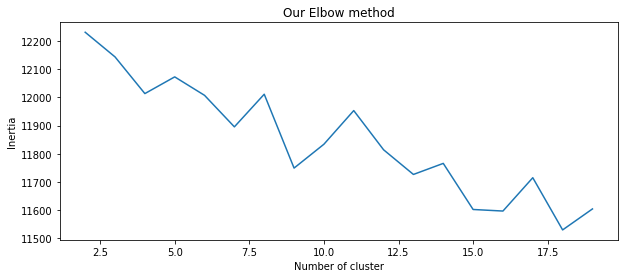

In [286]:
# plot of Our Elbow method
plt.figure(figsize=(10,4))
plt.plot([x for x in range(2,20)], variance)
plt.title('Our Elbow method')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

Here we can see that the Kmeans method is not a perfect model to evaluate the best classification because it may converge to a bad solution.
It depends on the initial random choice of each cluster. Cost function decreases at each step but there are more local minimums.

## Point 2: Implement version of k-means++

In [67]:
slice = matrix_df.iloc[:,1:]
elbow = {}
for k in tqdm(range(2, 20)):
    model = KMeans(k)
    model.fit(slice)
    model.predict(slice)    
    elbow[k] = model.inertia_

100%|██████████| 18/18 [15:20<00:00, 51.17s/it]


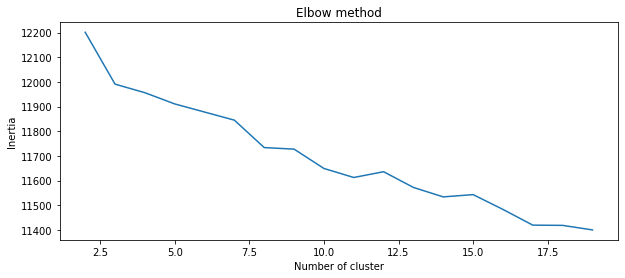

In [287]:
plt.figure(figsize=(10,4))
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.title('Elbow method')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

The main difference our k-means and k-means++ is about the number of iterations because our algorithm stops after 10 iterations instead sklearn k-means++ extends the maximun number of iterations until 300. Moreover, k-means++ uses another condition called 'tol' which set the tolerance level of the Euclidean norm in the cluster centers of two consecutive iterations in order to declare convergence.
So final inertia is lower than our one. Furthermore k-means algorithm is really dependent on the initialization of the centroids, since in our analysis we set the centroids randomly, in the k-means++ the initialization set the centroids typically distant from each other, leading to probably better results than random initialization.
In K-means++ you pick the initial centroids using an algorithm that tries to initialize centroids that are far apart from each other.
You pick a point randomly and that's your first centroid, then you pick the next point based on a probability that depends on the distance to the first point, the further apart the point is the more probable it is.

$

### 11 cluster analysis

We decide to take into account 11 clusters because after k=11 the increase of computational complexity isn't proportional to the decrease of inertia.

In [90]:
def our_clusters(matrix_df):
    point_matrix = matrix_df.iloc[:,1:]             # slice the ProductId from the matrix
    centroids = initial_centroids(11, point_matrix)  # initialize the k centroids  
    cluster = create_clusters(centroids, point_matrix)  # assign the point to the closest centroid
    cluster_df = pd.concat([point_matrix,pd.DataFrame(cluster,columns=['cluster'])], axis=1)
    variance_iter=[inertia(cluster,centroids, cluster_df)]

    print('Initial inertial :',variance_iter[0])
    iter = 10
    for i in tqdm(range(1,iter)):
        new_centroids, cluster_df = update_centroids(cluster, point_matrix) # update the k centroids
        cluster = create_clusters(new_centroids, point_matrix)              # update cluster
        variance_iter.append(inertia(cluster, new_centroids, cluster_df))# take inertia of each iterations
        print('Iteration %d:  inertia :%d' %(i,variance_iter[i]))
    
    # plot inertia's variation vs number of iterations
    plt.figure(figsize=(9,12))
    plt.plot([x for x in range (0,iter)],variance_iter)
    plt.xlabel('Number of iterations')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()
    
    return cluster

  0%|          | 0/9 [00:00<?, ?it/s]

Initial inertial : 17529.52614000812


 11%|█         | 1/9 [00:56<07:34, 56.81s/it]

Iteration 1:  inertia :11934


 22%|██▏       | 2/9 [01:53<06:36, 56.71s/it]

Iteration 2:  inertia :11845


 33%|███▎      | 3/9 [02:48<05:38, 56.40s/it]

Iteration 3:  inertia :11823


 44%|████▍     | 4/9 [03:48<04:47, 57.40s/it]

Iteration 4:  inertia :11783


 56%|█████▌    | 5/9 [04:45<03:48, 57.10s/it]

Iteration 5:  inertia :11768


 67%|██████▋   | 6/9 [05:43<02:52, 57.35s/it]

Iteration 6:  inertia :11767


 78%|███████▊  | 7/9 [06:43<01:56, 58.30s/it]

Iteration 7:  inertia :11767


 89%|████████▉ | 8/9 [07:43<00:58, 58.70s/it]

Iteration 8:  inertia :11766


100%|██████████| 9/9 [08:43<00:00, 58.16s/it]

Iteration 9:  inertia :11766


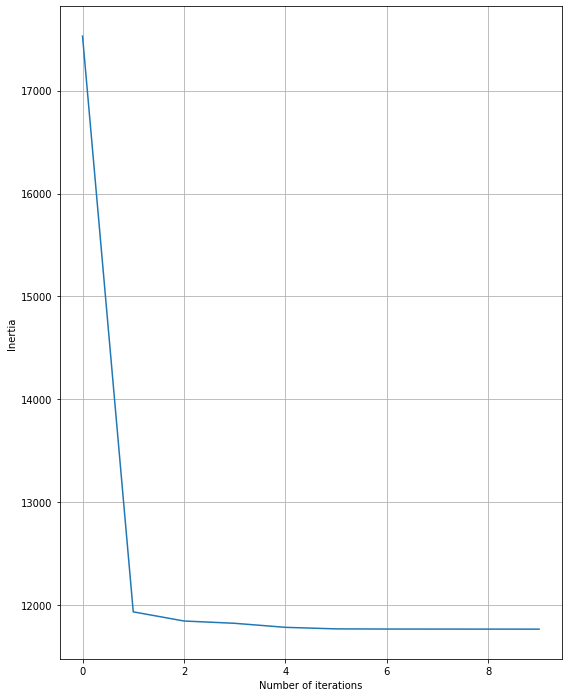

In [91]:
clusters = our_clusters(matrix_df)

As we can see, the inertia decreases as the number of iterations increase, converging after 10 iterations.

We add the column 'cluster' to the dataset of the unique products.

In [109]:
df['clusters']=clusters

In [293]:
with open('df_with_cluster.pkl', 'wb') as handle:
    pickle.dump(df, handle)

In [ ]:
with open('df_with_cluster.pkl', 'rb') as handle:
    df = pickle.load(handle)

## CLUSTER ANALYSIS

### QUESTION 1

In [138]:
def word_cluster(dataset_cluster):
    '''the word_cluster function get all the text of each cluster and 
       idetify the kind of product in the cluster
    '''
    wordcloud_lst = []       #initiliaze the wordcloud list
    for cluster in set(dataset_cluster['clusters']):
        review =dataset_cluster[dataset_cluster['clusters']==cluster]['Reviews_Text'] #slice reviews of each cluster

        text=''
        for r in review:
            text+= ' '.join(r)+' '  # merge the review of each cluster into sigle one text

        wordcloud = WordCloud(background_color="black",width=400, height=200).generate(text) #generate the wordcloud array
        wordcloud_lst.append(wordcloud)  

    return wordcloud_lst

In [ ]:
def plot_wordcloud(wordcloud_lst):
    '''the plot_wordcloud function plot all the wordcloud
    '''
    fig = plt.figure()
    for i in range(len(wordcloud_lst)):
        ax = fig.add_subplot(6,2,i+1)
        wordcloud = wordcloud_lst[i]
        ax.set(title = ' Main word in cluster %d'%i)
        ax.imshow(wordcloud)
        ax.axis('off')

    # Title the figure
    fig.suptitle('Word analysis', fontsize=30, fontweight='bold')
    fig.set_figwidth(20)
    fig.set_figheight(20)
    plt.show()

In [139]:
wordcloud_lst = word_cluster(df)

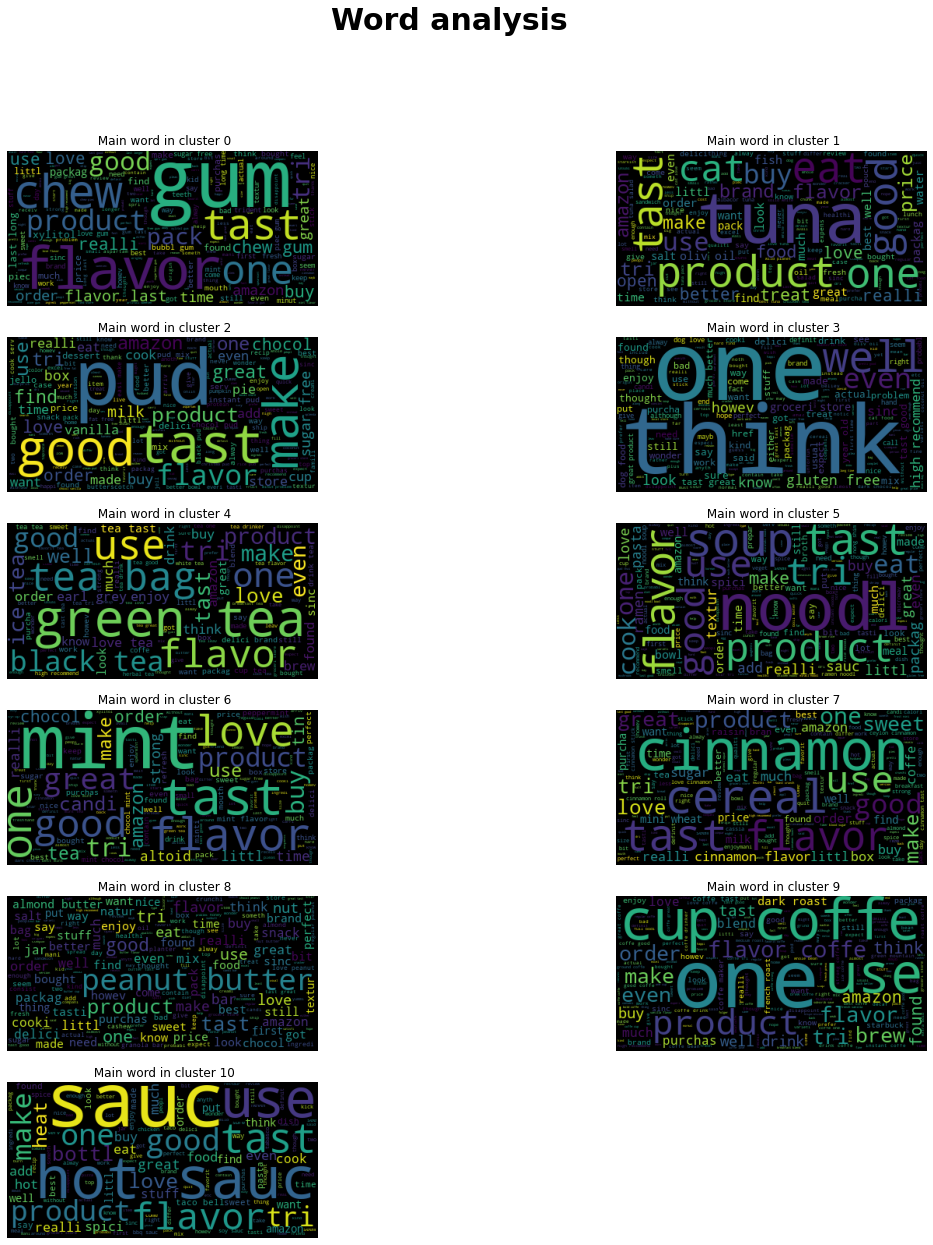

In [151]:
plot_wordcloud(wordcloud_lst)

### QUESTION 2

In [182]:
#NUMBER OF PRODUCT IN EACH CLUSTER
def number_of_product(df):
    
    print(df.groupby(df['clusters']).ProductId.count())
    cluster=list(set(df['clusters']))
    plt.figure(figsize=(15,8))
    plt.plot(cluster,df.groupby(df['clusters']).ProductId.count(),'ro-')
    plt.title('Number of product in each cluster')
    plt.xlabel('cluster')
    plt.ylabel('number of product')
    plt.grid()
    plt.show()
    

          ProductId
clusters           
0               677
1               208
2               114
3             53063
4              4664
5               705
6               368
7               334
8              1367
9              3985
10             2072


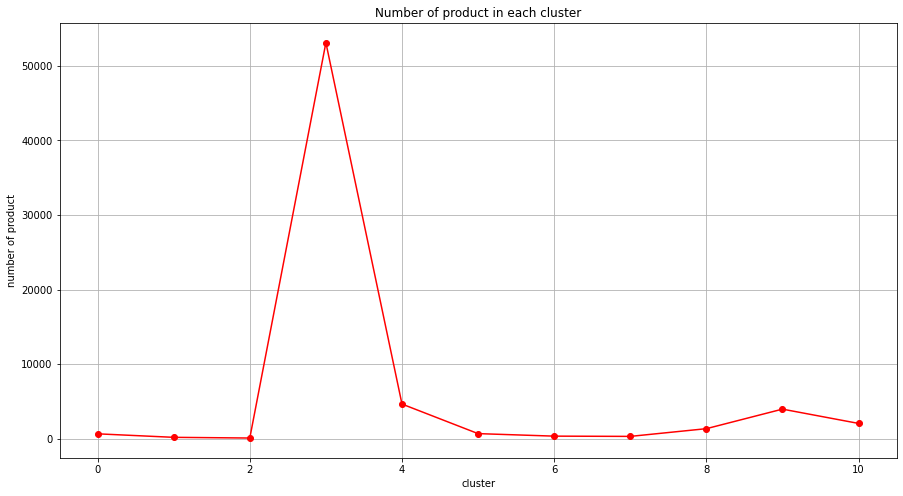

In [183]:
number_of_product(df)

### QUESTION 3

In [229]:
#Compute the reviews' score distribution in each cluster. 
#Once you get them, test if their mean differences are statistically significant!

def score_rev(df,dataset_iniziale):
    dist_score = []
    score_mean = []
    clusters=list(set(df['clusters']))
    for i in clusters:
        prodotti=list(df[df['clusters']==i].ProductId)
        prodotti_data_iniziale=dataset_iniziale[dataset_iniziale['ProductId'].isin(prodotti)]
        score_mean.append(prodotti_data_iniziale.Score.mean())
        score=prodotti_data_iniziale.Score
        dist_score.append(score)

        
    plt.figure(figsize=(9,6))
    plt.plot(clusters,score_mean,'-o')
    plt.title('SCORE REVIEW')
    plt.xlabel('cluster')
    plt.ylabel('mean score')
    plt.show()
    
    return dist_score

In [260]:
def plot_score_distribution(dist_score):
    
    fig = plt.figure(figsize=(15,12))
    for i in range(len(dist_score)):
        ax = fig.add_subplot(6,2,i+1)
        dist_score_i = dist_score[i]
        sns.distplot(dist_score_i, kde=False)
        ax.set(title = ' Score distribution %d'%i, xlabel = 'Score', ylabel = 'Number of score')

    # Title the figure
    fig.set_figwidth(20)
    fig.set_figheight(40)
    plt.show()

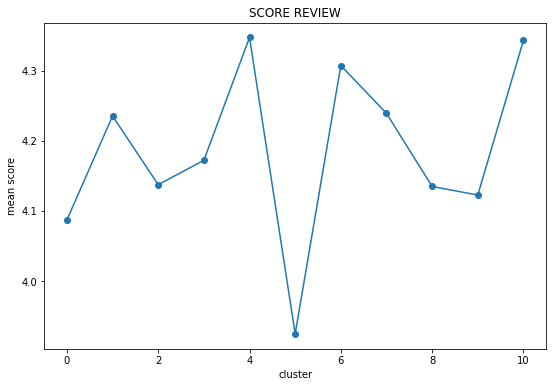

In [231]:
dist_score = score_rev(df, final)

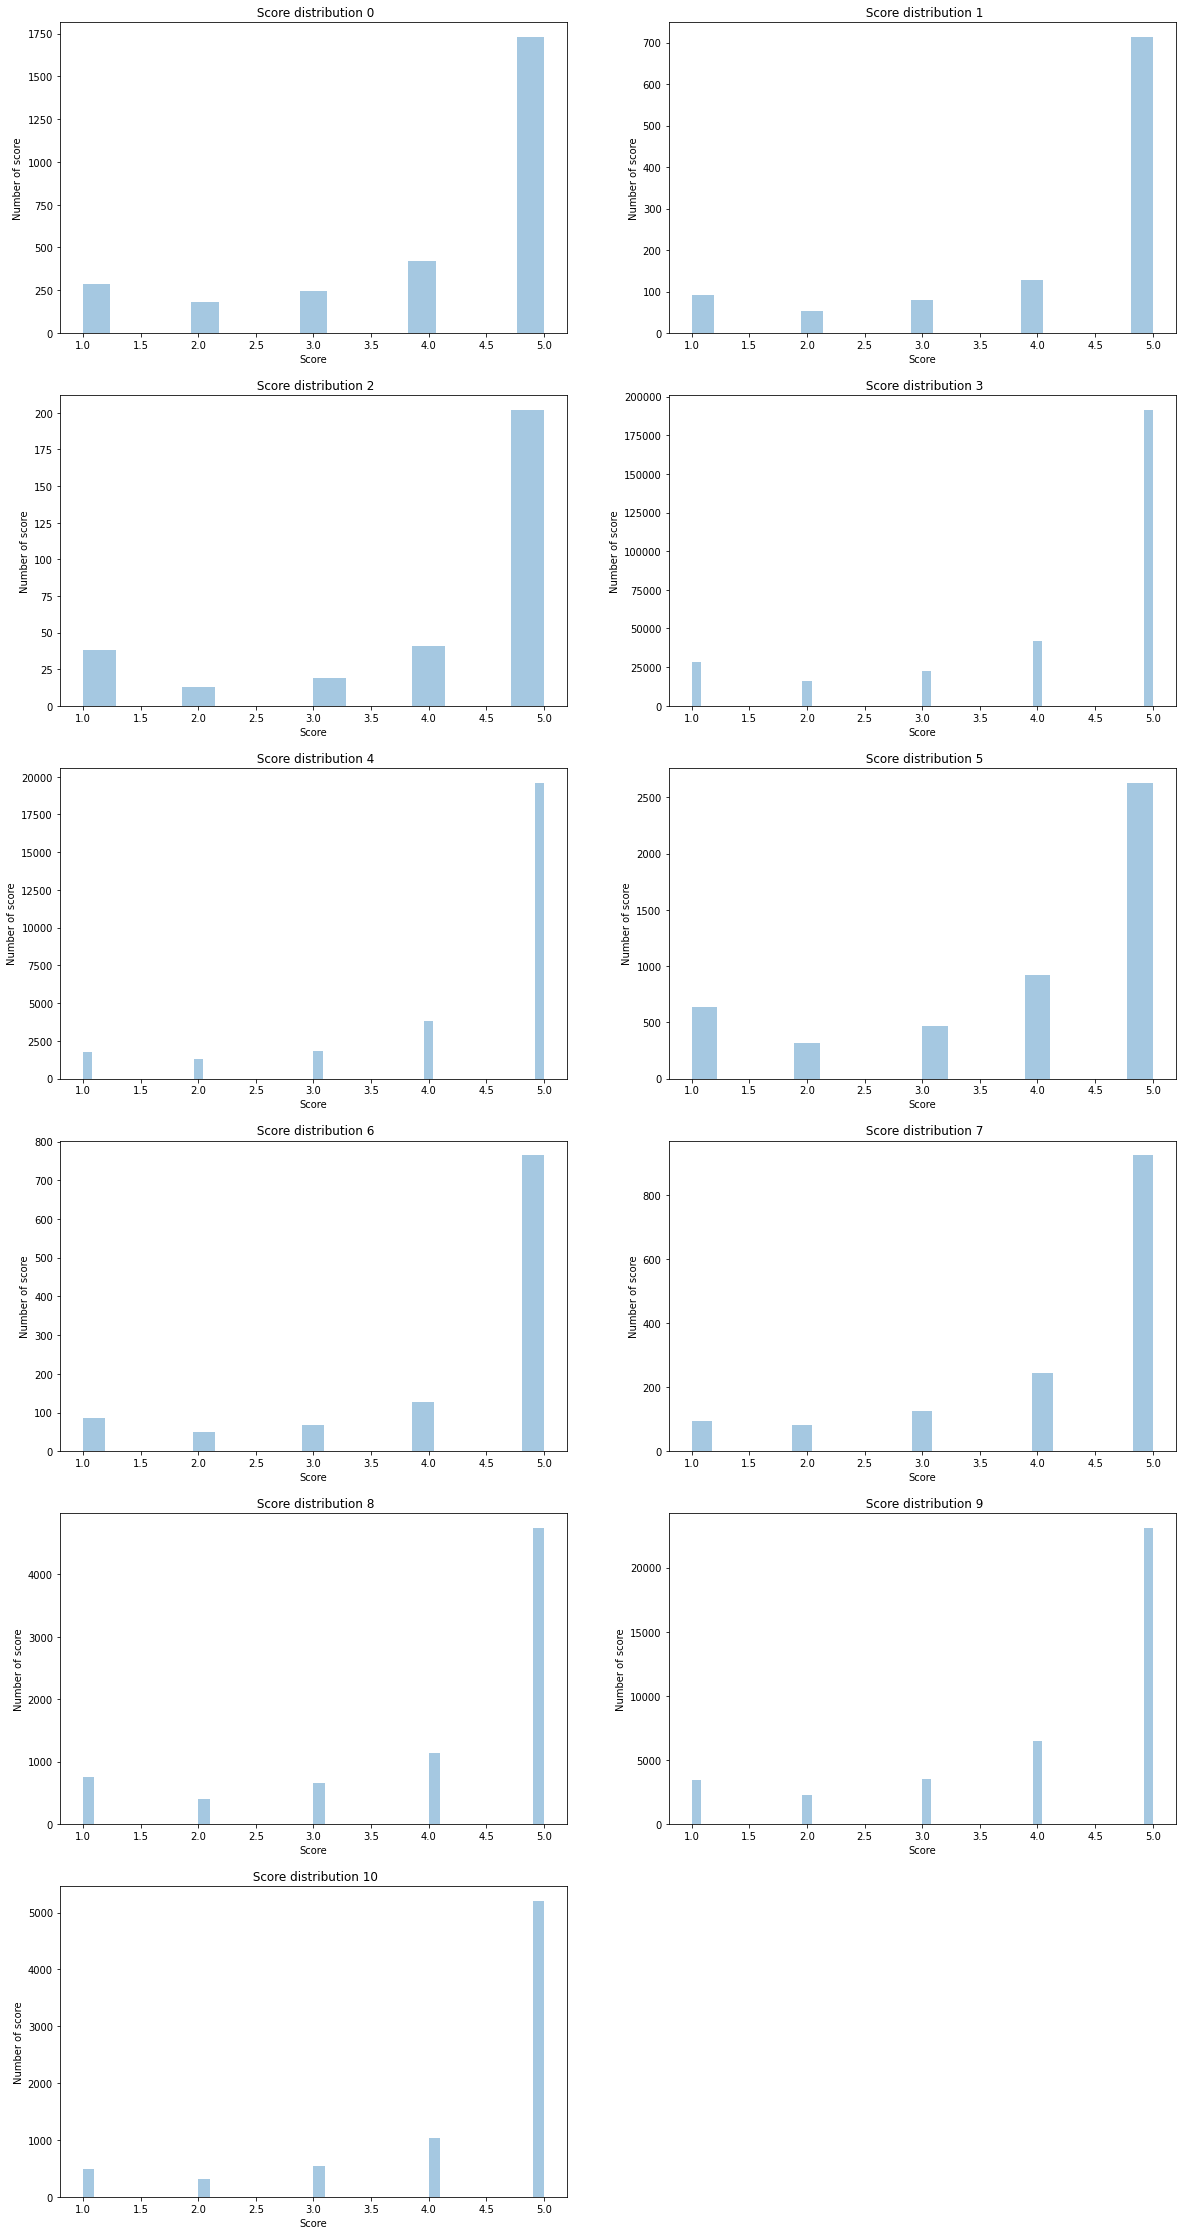

In [261]:
plot_score_distribution(dist_score)

In [253]:
print('p-value of Kruskal-Wallis H-test: {}'.format(scipy.stats.mstats.kruskalwallis(np.array(dist_score[0]),np.array(dist_score[1]),np.array(dist_score[2]),
                                 np.array(dist_score[3]),np.array(dist_score[4]),np.array(dist_score[5]),
                                 np.array(dist_score[6]),np.array(dist_score[7]),np.array(dist_score[8]),
                                 np.array(dist_score[9]),np.array(dist_score[10]))[1]))

p-value of Kruskal-Wallis H-test: 8.924928319184927e-218


### QUESTION 4

In [268]:
## Get the number of unique users writing reviews in each cluster
def unique_user(df,dataset_iniziale):
    user_uni= []
    clusters=list(set(df['clusters']))
    for i in clusters:
        prodotti=list(df[df['clusters']==i].ProductId)
        user=dataset_iniziale[dataset_iniziale['ProductId'].isin(prodotti)]['UserId']
        user_uni.append(user.nunique())
    plt.figure(figsize=(15,8))
    sns.barplot(x=clusters, y=user_uni)
    plt.title('Number of unique users writing review in each cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Unique users')
    plt.show()
    print('Number of unique users per cluster: {}'.format(user_uni))


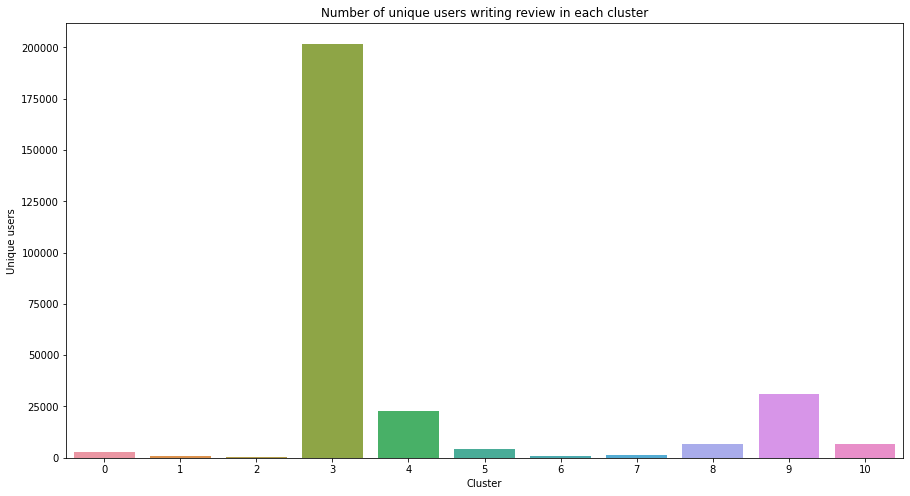

Number of unique users per cluster: [2589, 982, 300, 201809, 22901, 4398, 1053, 1409, 6917, 31301, 6544]


In [269]:
unique_user(df,final)